In [41]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
from skimage.io import imread
import os
import cv2
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras import optimizers, applications
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from tensorflow.keras.applications import EfficientNetB0, ResNet50, DenseNet121
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve,  auc, ConfusionMatrixDisplay

from tensorflow.keras.applications import VGG16, VGG19, InceptionV3
import albumentations as A
from tensorflow.keras.utils import to_categorical

In [2]:
test = pd.read_csv('../Final_projec/aptos2019-blindness-detection/test.csv')
train = pd.read_csv('../Final_projec/aptos2019-blindness-detection/train.csv')

In [3]:
print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])
display(train.head())

Number of train samples:  3662
Number of test samples:  1928


,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


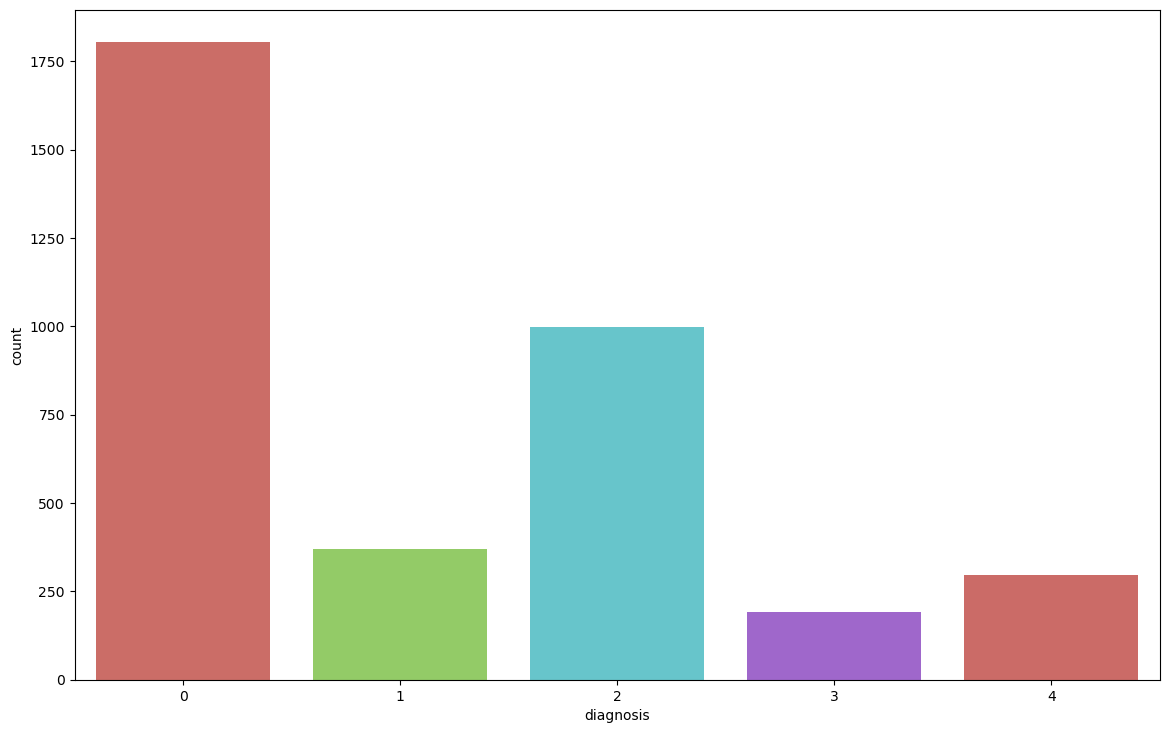

In [4]:
f, ax = plt.subplots(figsize=(14, 8.7))
ax = sns.countplot(x='diagnosis', hue='diagnosis', data=train, palette="hls", legend=False)
plt.show()

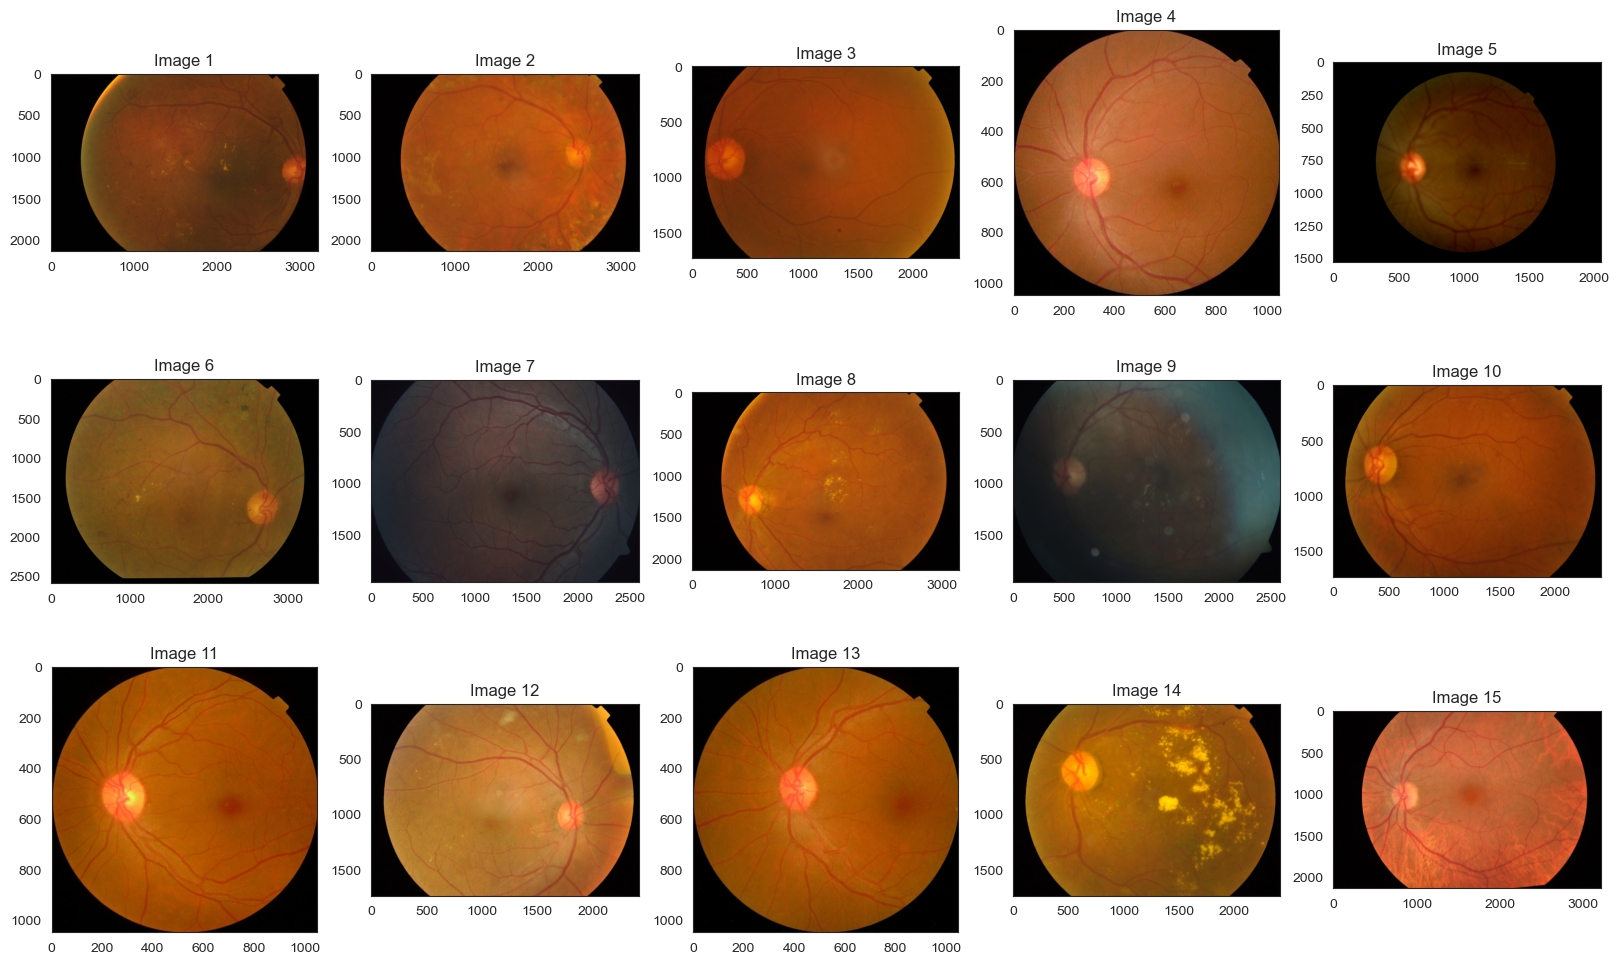

In [5]:
sns.set_style("white")
count = 1
plt.figure(figsize=[20, 20])
for img_name in train['id_code'][:15]:
    img = cv2.imread("../Final_projec/aptos2019-blindness-detection/train_images/%s.png" % img_name)[...,[2, 1, 0]]
    plt.subplot(5, 5, count)
    plt.imshow(img)
    plt.title("Image %s" % count)
    count += 1
    
plt.show()

In [6]:
print("Image IDs and Labels (TRAIN)")
train_df = pd.read_csv('../Final_projec/aptos2019-blindness-detection/train.csv')
train_df['id_code'] = train_df['id_code'] + ".png"
print(f"Training images: {train_df.shape[0]}")
display(train_df.head())
print("Image IDs (TEST)")
test_df = pd.read_csv('../Final_projec/aptos2019-blindness-detection/test.csv')
test_df['id_code'] = test_df['id_code'] + ".png"
print(f"Testing Images: {test_df.shape[0]}")
display(test_df.head())

Image IDs and Labels (TRAIN)
Training images: 3662


,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


Image IDs (TEST)
Testing Images: 1928


,id_code
0,0005cfc8afb6.png
1,003f0afdcd15.png
2,006efc72b638.png
3,00836aaacf06.png
4,009245722fa4.png


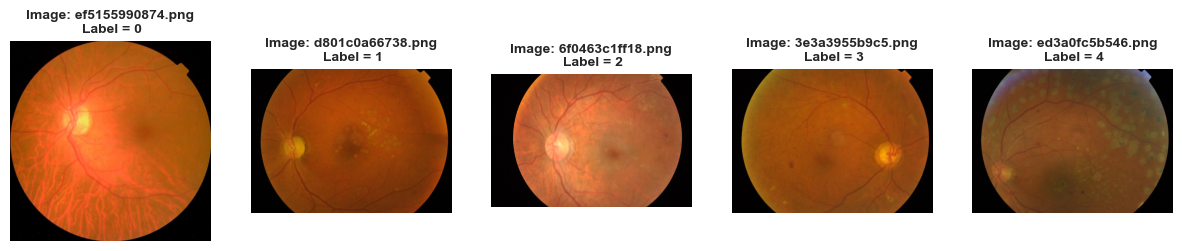

In [8]:
TRAIN_IMG_PATH = '../Final_projec/aptos2019-blindness-detection/' + "train_images/"
SEED = 42
fig, ax = plt.subplots(1,5,figsize = (15,5))
for i in range(5):
    sample = train_df[train_df.diagnosis == i].sample(1,random_state=SEED)
    image_name = sample['id_code'].item()
    X = cv2.cvtColor(cv2.imread(f'{TRAIN_IMG_PATH}{image_name}'), cv2.COLOR_BGR2RGB)
    ax[i].set_title(f"Image: {image_name}\n Label = {sample['diagnosis'].item()}", weight='bold', fontsize=10)
    ax[i].axis('off')
    ax[i].imshow(X)

In [9]:
def load_and_preprocess_image(image_id):
    image = cv2.imread(f'{TRAIN_IMG_PATH}{image_id}')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))

    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray_eq = cv2.equalizeHist(gray)

    augmentations = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.Affine(scale=(0.95, 1.05), translate_percent=(-0.05, 0.05), rotate=(-15, 15), p=0.5),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.3) 
    ])
    
    augmented = augmentations(image=image)
    image = augmented['image'] / 255.0  # Normalize

    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    image = (image - mean) / std
    
    return image

In [10]:
X = train_df['id_code'].values  # Only the image IDs
y = pd.get_dummies(train_df['diagnosis']).values

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=1)

In [11]:
X_train_processed = np.array([load_and_preprocess_image(img) for img in X_train])
X_val_processed = np.array([load_and_preprocess_image(img) for img in X_val])

/var/folders/5w/x0d0ydvs65d_b5ddbmbffwjm0000gn/T/ipykernel_23264/1186716806.py:13: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.3)


In [12]:
def build_model(base_model, input_shape=(224, 224, 3), num_classes=5):
    inputs = Input(shape=input_shape)
    x = base_model(include_top=False, weights='imagenet', input_tensor=inputs)
    x = GlobalAveragePooling2D()(x.output)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
callbacks = [early_stop, reduce_lr]


In [13]:
vgg_model = build_model(VGG19)
history_vgg = vgg_model.fit(X_train_processed, y_train,
                            validation_data=(X_val_processed, y_val),
                            epochs=25, batch_size=32, callbacks=callbacks)

Epoch 1/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 1355s 15s/step - accuracy: 0.4897 - loss: 1.3247 - val_accuracy: 0.6357 - val_loss: 0.9762 - learning_rate: 1.0000e-04
Epoch 2/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 1414s 15s/step - accuracy: 0.6567 - loss: 0.9537 - val_accuracy: 0.6958 - val_loss: 0.8541 - learning_rate: 1.0000e-04
Epoch 3/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 1414s 15s/step - accuracy: 0.7132 - loss: 0.8747 - val_accuracy: 0.7067 - val_loss: 0.8814 - learning_rate: 1.0000e-04
Epoch 4/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 9634s 106s/step - accuracy: 0.7008 - loss: 0.8922 - val_accuracy: 0.7040 - val_loss: 0.8438 - learning_rate: 1.0000e-04
Epoch 5/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 1475s 16s/step - accuracy: 0.7142 - loss: 0.8296 - val_accuracy: 0.7080 - val_loss: 0.8250 - learning_rate: 1.0000e-04
Epoch 6/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 1564s 17s/step - accuracy: 0.7203 - loss: 0.8077 - val_accuracy: 0.7121 - val_loss: 0.7707 - learning_rate: 1.0000e-04
Epoch 7/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 17897s 196s/step - 

In [14]:
inception_model = build_model(InceptionV3)
history_inception = inception_model.fit(X_train_processed, y_train,
                                        validation_data=(X_val_processed, y_val),
                                        epochs=25, batch_size=32, callbacks=callbacks)


Epoch 1/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 318s 3s/step - accuracy: 0.5161 - loss: 1.3314 - val_accuracy: 0.7026 - val_loss: 0.9761 - learning_rate: 1.0000e-04
Epoch 2/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 311s 3s/step - accuracy: 0.7326 - loss: 0.7468 - val_accuracy: 0.7299 - val_loss: 0.7999 - learning_rate: 1.0000e-04
Epoch 3/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 294s 3s/step - accuracy: 0.7693 - loss: 0.6030 - val_accuracy: 0.7394 - val_loss: 0.8529 - learning_rate: 1.0000e-04
Epoch 4/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 2596s 28s/step - accuracy: 0.8204 - loss: 0.4842 - val_accuracy: 0.7190 - val_loss: 0.7726 - learning_rate: 1.0000e-04
Epoch 5/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 250s 3s/step - accuracy: 0.8608 - loss: 0.3850 - val_accuracy: 0.6862 - val_loss: 0.9324 - learning_rate: 1.0000e-04
Epoch 6/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 294s 3s/step - accuracy: 0.8944 - loss: 0.2960 - val_accuracy: 0.7462 - val_loss: 0.9076 - learning_rate: 1.0000e-04
Epoch 7/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 319s 3s/step - accuracy: 0.927

In [15]:
resnet_model = build_model(ResNet50)
history_resnet = resnet_model.fit(X_train_processed, y_train,
                                  validation_data=(X_val_processed, y_val),
                                  epochs=25, batch_size=32, callbacks=callbacks)


Epoch 1/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 491s 5s/step - accuracy: 0.5670 - loss: 1.2094 - val_accuracy: 0.4925 - val_loss: 8.6214 - learning_rate: 1.0000e-04
Epoch 2/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 513s 6s/step - accuracy: 0.7379 - loss: 0.7050 - val_accuracy: 0.4925 - val_loss: 4.6917 - learning_rate: 1.0000e-04
Epoch 3/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 508s 6s/step - accuracy: 0.7762 - loss: 0.6000 - val_accuracy: 0.4925 - val_loss: 4.5991 - learning_rate: 1.0000e-04
Epoch 4/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 499s 5s/step - accuracy: 0.8328 - loss: 0.4287 - val_accuracy: 0.5689 - val_loss: 1.7596 - learning_rate: 1.0000e-04
Epoch 5/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 495s 5s/step - accuracy: 0.8689 - loss: 0.3558 - val_accuracy: 0.5512 - val_loss: 2.0196 - learning_rate: 1.0000e-04
Epoch 6/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 522s 6s/step - accuracy: 0.8975 - loss: 0.2837 - val_accuracy: 0.6003 - val_loss: 1.3921 - learning_rate: 1.0000e-04
Epoch 7/25
92/92 ━━━━━━━━━━━━━━━━━━━━ 499s 5s/step - accuracy: 0.9297 

In [29]:
def evaluate_model(model, X_val, y_val, model_name='Model'):
    y_pred_probs = model.predict(X_val)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_val, axis=1)

    report = classification_report(y_true, y_pred, output_dict=True)
    accuracy = report['accuracy']
    f1 = report['macro avg']['f1-score']
    precision = report['macro avg']['precision']
    recall = report['macro avg']['recall']
    roc_auc = roc_auc_score(y_val, y_pred_probs, multi_class='ovr')

    print(f'\n--- {model_name} Evaluation ---')
    print(classification_report(y_true, y_pred))
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("ROC AUC Score (macro):", roc_auc)

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'ROC_AUC_Macro': roc_auc,
        'F1_Score': f1,
        'Precision': precision,
        'Recall': recall
    }


In [30]:
results = []
results.append(evaluate_model(vgg_model, X_val_processed, y_val, 'VGG19'))
results.append(evaluate_model(inception_model, X_val_processed, y_val, 'InceptionV3'))
results.append(evaluate_model(resnet_model, X_val_processed, y_val, 'ResNet50'))


23/23 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step

--- VGG19 Evaluation ---
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       361
           1       0.59      0.32      0.41        85
           2       0.54      0.89      0.68       190
           3       1.00      0.03      0.06        33
           4       0.00      0.00      0.00        64

    accuracy                           0.75       733
   macro avg       0.62      0.44      0.42       733
weighted avg       0.72      0.75      0.70       733

Confusion Matrix:
[[351   5   5   0   0]
 [  9  27  49   0   0]
 [  9  11 170   0   0]
 [  2   0  28   1   2]
 [  1   3  60   0   0]]
ROC AUC Score (macro): 0.8935501539169435
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 505ms/step

--- InceptionV3 Evaluation ---
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       361
           1       0.52      0.32      0.39        85
           2       0.57      0.67

In [31]:
# Ensemble: VGG19 + InceptionV3
ensemble_soft_voting_2 = (pred_vgg + pred_incep) / 2
y_pred_ens2 = np.argmax(ensemble_soft_voting_2, axis=1)
y_true = np.argmax(y_val, axis=1)

report2 = classification_report(y_true, y_pred_ens2, output_dict=True)
acc_ensemble2 = report2['accuracy']
f1_ensemble2 = report2['macro avg']['f1-score']
prec_ensemble2 = report2['macro avg']['precision']
recall_ensemble2 = report2['macro avg']['recall']
auc_ensemble2 = roc_auc_score(y_val, ensemble_soft_voting_2, multi_class='ovr')

results.append({
    'Model': 'Ensemble (VGG+Incep)',
    'Accuracy': acc_ensemble2,
    'ROC_AUC_Macro': auc_ensemble2,
    'F1_Score': f1_ensemble2,
    'Precision': prec_ensemble2,
    'Recall': recall_ensemble2
})


In [32]:
# Ensemble: VGG19 + InceptionV3 + ResNet50
ensemble_soft_voting_3 = (pred_vgg + pred_incep + pred_resnet) / 3
y_pred_ens3 = np.argmax(ensemble_soft_voting_3, axis=1)

report3 = classification_report(y_true, y_pred_ens3, output_dict=True)
acc_ensemble3 = report3['accuracy']
f1_ensemble3 = report3['macro avg']['f1-score']
prec_ensemble3 = report3['macro avg']['precision']
recall_ensemble3 = report3['macro avg']['recall']
auc_ensemble3 = roc_auc_score(y_val, ensemble_soft_voting_3, multi_class='ovr')

results.append({
    'Model': 'Ensemble (All 3)',
    'Accuracy': acc_ensemble3,
    'ROC_AUC_Macro': auc_ensemble3,
    'F1_Score': f1_ensemble3,
    'Precision': prec_ensemble3,
    'Recall': recall_ensemble3
})

In [37]:
summary_df = pd.DataFrame(results)
summary_df


,Model,Accuracy,ROC_AUC_Macro,F1_Score,Precision,Recall
0,VGG19,0.748977,0.893550,0.421207,0.615075,0.442997
1,InceptionV3,0.718963,0.880727,0.489765,0.517680,0.478900
2,ResNet50,0.780355,0.904865,0.595193,0.653965,0.574915
3,Ensemble (VGG+Incep),0.758527,0.903390,0.482716,0.597173,0.478127
4,Ensemble (All 3),0.777626,0.916162,0.556068,0.666825,0.535287


In [38]:
def plot_roc_auc(y_true, y_probs, model_name):
    n_classes = y_probs.shape[1]
    plt.figure(figsize=(8, 6))

    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {model_name}')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()


In [39]:
def plot_conf_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix: {model_name}')
    plt.grid(False)
    plt.show()


23/23 ━━━━━━━━━━━━━━━━━━━━ 76s 3s/step


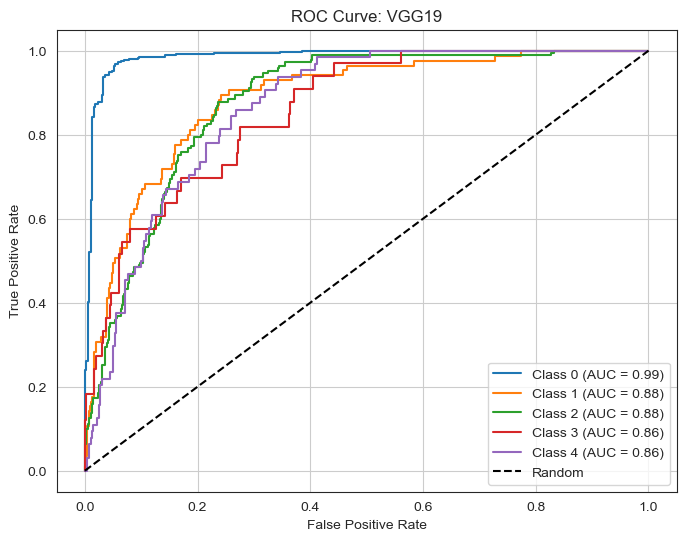

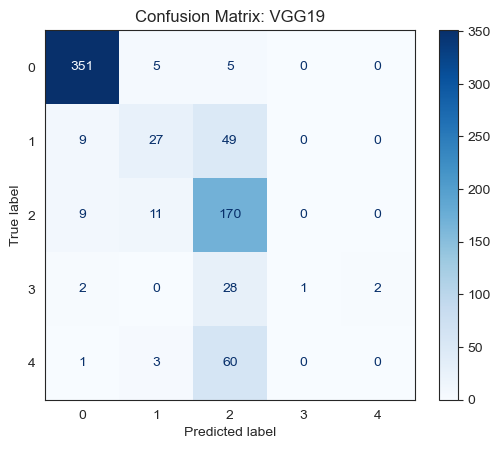

In [42]:
y_probs_vgg = vgg_model.predict(X_val_processed)
y_pred_vgg = np.argmax(y_probs_vgg, axis=1)
y_true = np.argmax(y_val, axis=1)

plot_roc_auc(y_val, y_probs_vgg, 'VGG19')
plot_conf_matrix(y_true, y_pred_vgg, 'VGG19')


23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 566ms/step


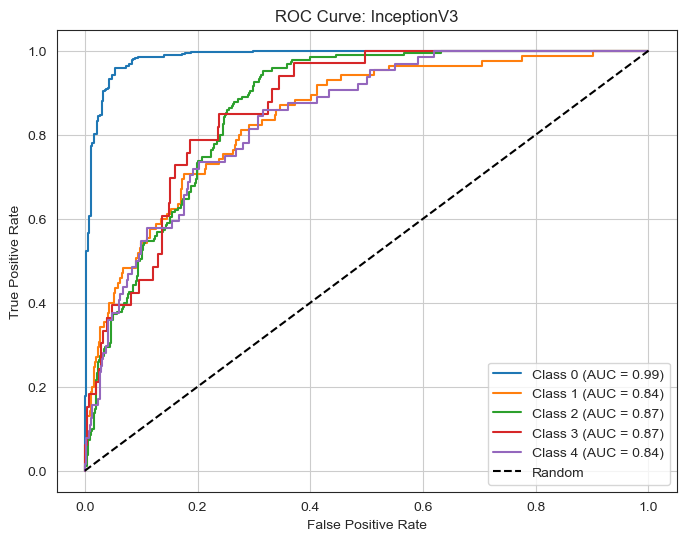

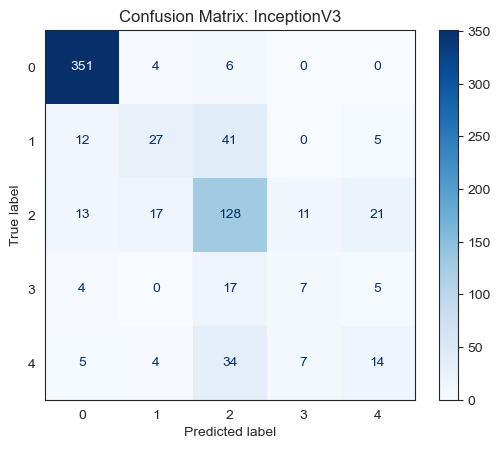

In [43]:
y_probs_incep = inception_model.predict(X_val_processed)
y_pred_incep = np.argmax(y_probs_incep, axis=1)

plot_roc_auc(y_val, y_probs_incep, 'InceptionV3')
plot_conf_matrix(y_true, y_pred_incep, 'InceptionV3')


23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 817ms/step


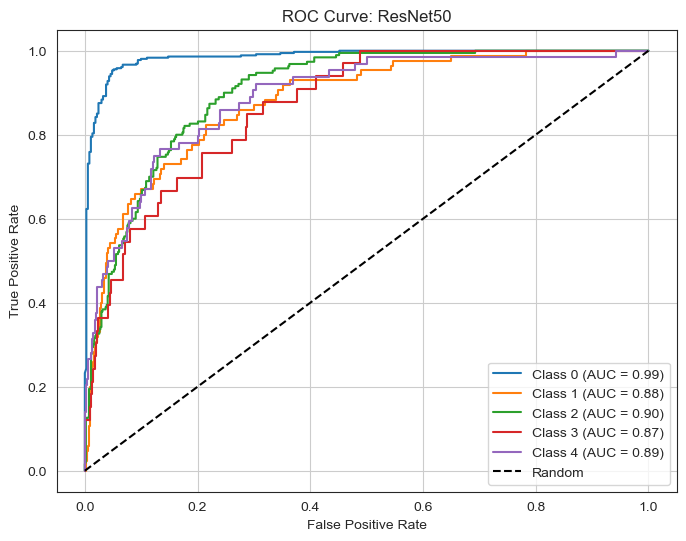

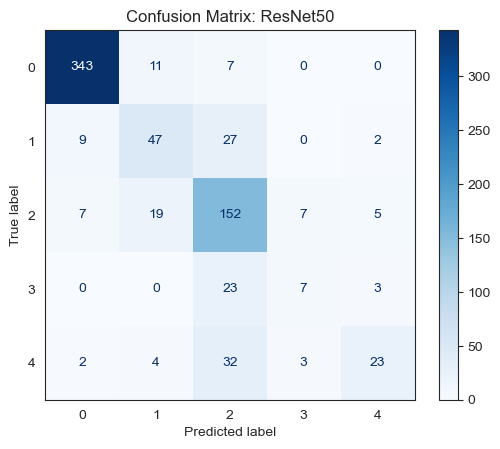

In [44]:
y_probs_resnet = resnet_model.predict(X_val_processed)
y_pred_resnet = np.argmax(y_probs_resnet, axis=1)

plot_roc_auc(y_val, y_probs_resnet, 'ResNet50')
plot_conf_matrix(y_true, y_pred_resnet, 'ResNet50')


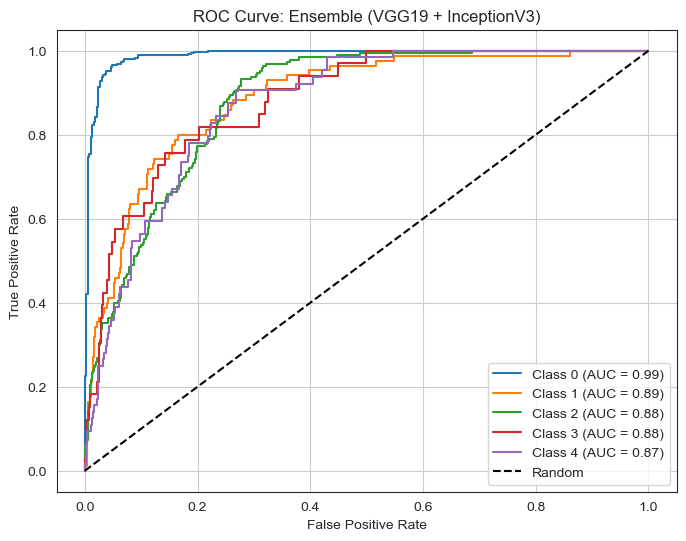

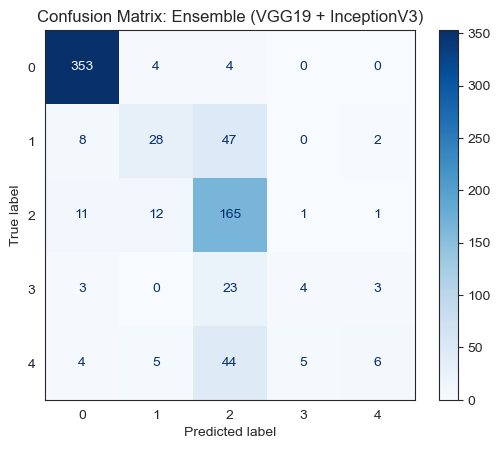

In [45]:
plot_roc_auc(y_val, ensemble_soft_voting_2, 'Ensemble (VGG19 + InceptionV3)')
plot_conf_matrix(y_true, y_pred_ens2, 'Ensemble (VGG19 + InceptionV3)')


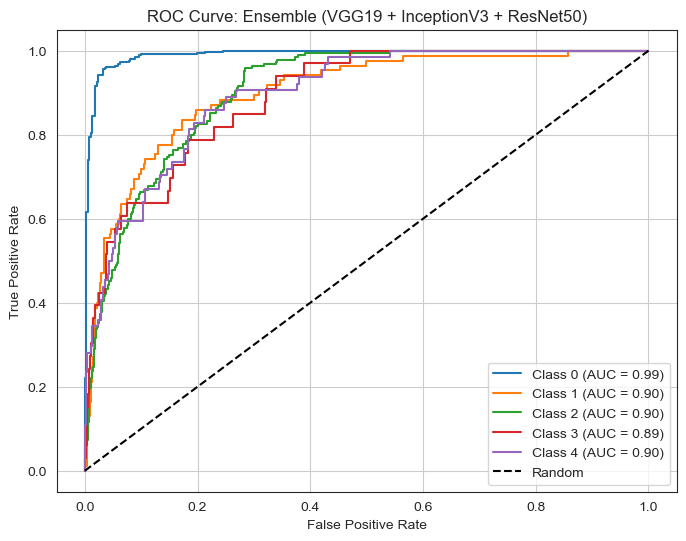

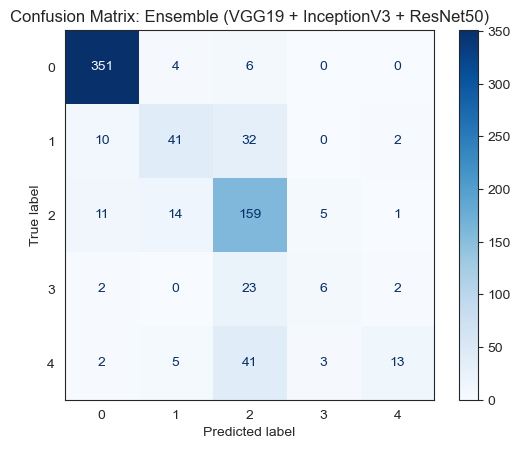

In [46]:
plot_roc_auc(y_val, ensemble_soft_voting_3, 'Ensemble (VGG19 + InceptionV3 + ResNet50)')
plot_conf_matrix(y_true, y_pred_ens3, 'Ensemble (VGG19 + InceptionV3 + ResNet50)')
